In [1]:
import sympy as sp
import jax.numpy as np
from jax import vmap
import matplotlib.pyplot as plt

from util.interfaces import Config, EqInfo, Hyperparameters, VarInfo
from main import run

## Problem
Malthusian growth model:

$ \displaystyle
\frac{dP}{dt} = rP
$

With initial conditions:

$ \displaystyle
P(1) = e^{r}
$

Analytical solution:
$ \displaystyle
P = e^{rt}
$

The `Config` object holds the equation specification and all hyperparameters. The following code block contains comments explaining what each of them do.

In [2]:
config = Config(
  # Differential equation specification
  eq = EqInfo(
    # Name of the variable to be solved for
    name = 'P',
    # Expression of the equation in the form 'expr = 0'. s is an object
    # containing all symbols specified in `vars`, plus the equation and all
    # derivatives up to 2nd order, e.g. dPdr meaning
    # \frac{\partial P}{\partial r}, d2Pdr2, dPdt, and d2Pdt2 similarly
    function = lambda s: s.dPdt - s.r * s.P,
  ),
  # Specification of available variable names and their intervals
  vars = {
    'r': VarInfo(bounds=(1, 2)), # r \in [1, 2]
    't': VarInfo(bounds=(0, 2)), # t \in [0, 2]
  },
  # Specification of initial and boundary conditions, and corresponding loss
  # scaling factor
  conditions = [
    (2, lambda s: s.P.subs(s.t, 1) - sp.exp(s.r)) # P(1) = e^r, loss scale: 2
  ],
  # Set of operations O_in for the edges from the input node
  preoperations = [
    lambda r, t: 0,
    lambda r, t: 1,
    lambda r, t: r,
    lambda r, t: t,
    lambda r, t: r * t
  ],
  # Set of operations O for all other edges. 2nd argument is a dict defined in
  # eq.function (s), can be used for more interesting operations
  operations = [
    lambda z, _: 0,
    lambda z, _: 1,
    lambda z, _: z,
    lambda z, _: -z,
    lambda z, _: z*z,
    lambda z, _: sp.exp(z),
  ],
  hyperparameters = Hyperparameters(
    # Learning rate
    lr = 0.01,
    # Alpha regularization penalty \gamma_reg
    penalty = 2,
    # Node count
    nodecount = 4,
  ),
  # Number of epochs between pruning
  epochs = 32,
  # Number of samples for each variable sampled from its boundaries
  samples = 512,
  # Batch size for gradient updates
  batchsize = 64,
  verbosity = 1,
  seed = 1,
)


The network is trained with the `run` function.

In [3]:
network, best, loss_histories = run(config)

11:52:03.570 [INFO] Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
11:52:03.571 [INFO] Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
11:52:03.573 [INFO] Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
11:52:03.573 [INFO] Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
11:52:03.726 [INFO] Constructed symbolic model
11:52:03.924 [INFO] Constructed loss equation
11:52:04.118 [INFO] Constructed JAXified model
11:52:06.115 [INFO] Epoch: 1, Loss: 49.3924102783
11:52:06.172 [INFO] Epoch: 2, Loss: 26.8270969391
11:52:06.217 [INFO] Epoch: 3, Loss: 18.4914360046
11:52:06.256 [INFO] Epoch: 4, Loss: 16.7927913666
11:52:06.301 [INFO] Epoch: 5, Loss: 8.6019496918
11:52:06

Nothing more to prune!


$\displaystyle 0.999999940395355 e^{1.0 r t} - 1.12404698882074 \cdot 10^{-7}$

Best loss: 1.3884763293541685e-13


The returned `best` object is a dictionary containing the symbolic expression in `model`, the symbolic weights and corresponding numeric values in `alphas` and `W` respectively, and the obtained (sampled) loss in `loss`.

In [4]:
prediction_best = best.model.subs(zip(best.alphas, best.W))
print(sp.latex(prediction_best))

0.999999940395355 e^{1.0 r t} - 1.12404698882074 \cdot 10^{-7}


# Plot

In [5]:
r = network.symbols.r
t = network.symbols.t

In [6]:
y_pred_fn = sp.lambdify([r, t], prediction_best)
y_real_fn = sp.lambdify([r, t], sp.exp(r*t))

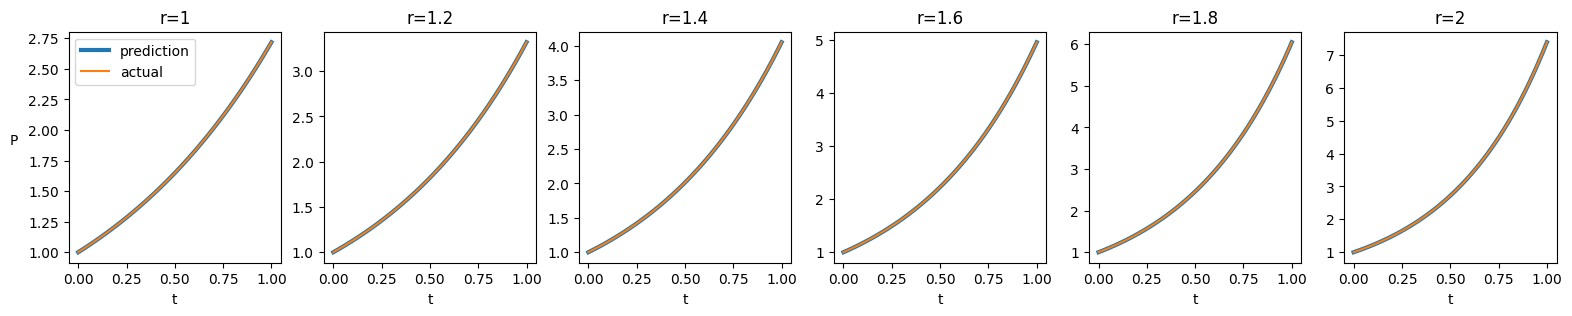

In [7]:
t_try = np.linspace(0, 1, 50)

r_tries = [1, 1.2, 1.4, 1.6, 1.8, 2]
fig, axs = plt.subplots(1, len(r_tries))
fig.set_size_inches(len(r_tries)*3.2, 3)

for ax, r_try in zip(axs, r_tries):
  ax.set_title(f'r={r_try}')
  ax.plot(t_try, y_pred_fn(r_try, t_try), label=f'prediction', linewidth=3)
  ax.plot(t_try, y_real_fn(r_try, t_try), label=f'actual')
  ax.set_xlabel('t')
axs[0].legend()
axs[0].set_ylabel('P', rotation=0, labelpad=10)
plt.show()

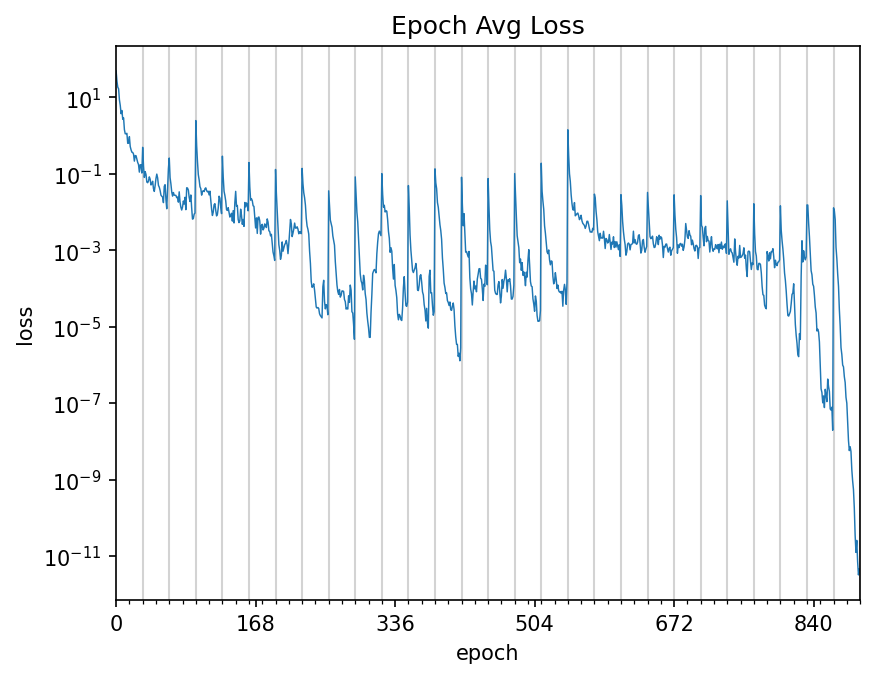

In [8]:
loss_history = []
prunepoints = []

for pruneepoch in loss_histories:
  count = 0 if len(prunepoints) == 0 else prunepoints[len(prunepoints)-1]
  for epoch in pruneepoch:
    loss_history += [np.average(np.array(epoch))]
    count += 1
  prunepoints += [count]

plt.title('Epoch Avg Loss')
plt.xlabel('epoch')
plt.xlim((0, prunepoints[len(prunepoints) - 1]))
# plt.ylim((min(loss_history)*0.5, 2))
plt.gcf().gca().xaxis.set_major_locator(plt.MultipleLocator(168))
plt.gcf().gca().xaxis.set_minor_locator(plt.MultipleLocator(16))
plt.yscale('log')
plt.ylabel('loss')
for prunepoint in prunepoints:
  plt.axvline(prunepoint, color='lightgrey', linewidth=1)
plt.plot(loss_history, linewidth=0.7)
plt.gcf().set_dpi(150)
plt.show()

# Test

In [15]:
dPdt = sp.diff(prediction_best, 't')

error = dPdt - network.symbols.r * prediction_best
error_c1 = prediction_best.subs(network.symbols.t, 1) - sp.exp(network.symbols.r)

errorexpr = sp.integrate(error**2 + error_c1**2, *config.getSymbolsIntegrals())
print(sp.latex(float(errorexpr)))

3.80403517432048 \cdot 10^{-13}


In [10]:
loss = (sp.diff(sp.exp(r*t), t) - r * sp.exp(r*t))**2

sp.integrate(loss, ('t', *config.vars['t'].bounds), ('r', *config.vars['r'].bounds))

0